# Libraries

In [1]:
import os
import random
from dataclasses import dataclass

from tqdm import tqdm

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

from diffusers import UNet2DModel
from torchvision.models import resnet50, ResNet50_Weights
from diffusers import DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup
from accelerate import Accelerator

from datasets import load_dataset

from matplotlib import pyplot as plt
from PIL import Image

# Config

In [2]:
@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    batch_size = 16
    num_epochs = 100
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    device = "cuda"

    random_state = 42 


config = TrainingConfig()

In [3]:
def seed_everything(seed: int,
                    use_deterministic_algos: bool = False) -> None:
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(use_deterministic_algos)
    random.seed(seed)


seed_everything(config.random_state)

# Utils

In [4]:
def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im

# Data

In [5]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset("food101", split='train')

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images, "label": examples["label"]}


dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=config.batch_size, shuffle=True
)

# Model, Samplers, Optimizers, Schedulers

In [6]:
T = torch.load("food101_conditional_ddpm/model_74.pt")
S = torch.load("food101_conditional_ddpm/model_74.pt")
D = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
D.fc = nn.Linear(2048, 2)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="linear")

# S_noise_scheduler = DDPMScheduler(
#     num_train_timesteps=4, 
#     beta_schedule="linear",
#     beta_start=0.0001,
#     beta_end=1.0
# )
# S_noise_scheduler.set_timesteps(num_inference_steps=4)

S_optimizer = torch.optim.AdamW(S.parameters(), lr=3e-5)
D_optimizer = torch.optim.AdamW(D.parameters(), lr=3e-4)

S_scheduler = get_cosine_schedule_with_warmup(
    optimizer=S_optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

D_scheduler = get_cosine_schedule_with_warmup(
    optimizer=D_optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

# Loops

In [7]:
def add_zero_class(y):
    bs = y.shape[0]

    y = (y + 1) * (torch.rand((bs,)) >= 0.1).long().to(y.device)
    return y

In [8]:
def forward_diffusion_process(x, noise_scheduler, device: str = "cuda", num_timesteps: int = 1000):
    bs = x.shape[0]
    noise_scheduler.set_timesteps(num_inference_steps=num_timesteps)

    noise = torch.randn_like(x)
    random_t_index = random.randint(0, num_timesteps - 1)
    t = noise_scheduler.timesteps[random_t_index]
    t_batch = torch.full(
        size=(x.shape[0],), 
        fill_value=t, 
        dtype=torch.long
    ).to(device)
    
    noisy_x = noise_scheduler.add_noise(x, noise, t_batch)

    return noisy_x, random_t_index


def backward_diffusion_process(x, t, y, model, noise_scheduler, device: str = "cuda", num_timesteps: int = 1000):
    bs = x.shape[0]
    noise_scheduler.set_timesteps(num_inference_steps=num_timesteps)
    
    for t in noise_scheduler.timesteps[-t - 1:]:
        model_input = noise_scheduler.scale_model_input(x, t)

        t_batch = torch.full(
            size=(bs,), 
            fill_value=t.item(), 
            dtype=torch.long
        ).to(device)

        noise_pred = model(
            model_input, t_batch, y, return_dict=False
        )[0]

        x = noise_scheduler.step(noise_pred, t, x).prev_sample

    return x


In [9]:
def train_epoch(S, T, D, S_optimizer, D_optimizer, accelerator, adversarial_loss, reconstruction_loss, lambd, dataloader, device):
    S.train()
    T.eval()
    D.train()

    S_losses = []
    D_losses = []
    
    for batch in tqdm(dataloader):
        x = batch["images"]
        labels = add_zero_class(batch["label"])
        
        noise = torch.randn_like(x).to(device)
        
        bs = x.shape[0]
        target_real = torch.ones((bs,), dtype=torch.long, device=device)
        target_fake = torch.zeros((bs,), dtype=torch.long, device=device)

        # Foward diffusion process on clean image
        xs, s = forward_diffusion_process(x, noise_scheduler, num_timesteps=4)

        # Train ADD-student
        # Backward diffusion process on noised image, using noisy_images and t
        S_optimizer.zero_grad()
        x_theta = backward_diffusion_process(xs, s, labels, S, noise_scheduler, num_timesteps=4)
        L_G_adv = adversarial_loss(D(x_theta), target_real)

        # Foward diffusion process on an image denoised by ADD-student
        xt, t = forward_diffusion_process(x, noise_scheduler, num_timesteps=1000)
        with torch.no_grad():
            x_psi = backward_diffusion_process(xt, t, labels, T, noise_scheduler, num_timesteps=1000)

        с = 1 / (t + 1)
        d = reconstruction_loss(x_theta, x_psi) * с # * c(t), where c(t) = a_t

        S_loss = L_G_adv + lambd * d
                
        # accelerator.clip_grad_norm_(S.parameters(), 1.0)                     
        accelerator.backward(S_loss)
        S_optimizer.step()
        
        # Train Descriminator
        D_optimizer.zero_grad()
        real_loss = adversarial_loss(D(x), target_real) # TODO: Need R1 regularization
        fake_loss = adversarial_loss(D(x_theta.detach()), target_fake)
        L_D_adv = (real_loss + fake_loss) / 2
        
        # accelerator.clip_grad_norm_(D.parameters(), 1.0)
        accelerator.backward(L_D_adv)
        D_optimizer.step()

        S_losses.append(S_loss.item())
        D_losses.append(L_D_adv.item())

    S_losses, D_losses = sum(S_losses) / len(dataloader.dataset), sum(D_losses) / len(dataloader.dataset)

    return S_losses, D_losses


def sample_images(model, noise_scheduler, device, c: int = 0, bs: int =16, num_inference_steps: int = 1000):
    model.train()
    model.to(device)

    x = torch.randn((bs, 3, 128, 128)).to(device)

    y_uncond = torch.zeros((bs,), device=config.device).long()
    y_cond = torch.ones((bs,), device=config.device).long() * c
    
    noise_scheduler.set_timesteps(num_inference_steps=num_inference_steps)

    for t in noise_scheduler.timesteps:
        model_input = noise_scheduler.scale_model_input(x, t)

        t_batch = torch.full(
            size=(x.shape[0],), 
            fill_value=t.item(), 
            dtype=torch.long
        ).to(device)

        with torch.no_grad():
            noise_pred = model(
                model_input, 
                t_batch, 
                y_cond,
                return_dict=False
            )[0]

        x = noise_scheduler.step(noise_pred, t, x).prev_sample

    return x


def sample_images_cfg(model, noise_scheduler, device, c: int = 0, w: float = 1, bs: int =16, num_inference_steps: int = 1000):
    model.train()
    model.to(device)

    x = torch.randn((bs, 3, 128, 128)).to(device)

    y_uncond = torch.zeros((bs,), device=config.device).long()
    y_cond = torch.ones((bs,), device=config.device).long() * c
    
    noise_scheduler.set_timesteps(num_inference_steps=num_inference_steps)

    for t in noise_scheduler.timesteps:
        model_input = noise_scheduler.scale_model_input(x, t)

        t_batch = torch.full(
            size=(x.shape[0],), 
            fill_value=t.item(), 
            dtype=torch.long
        ).to(device)

        with torch.no_grad():
            cond_noise_pred = model(
                model_input, 
                t_batch, 
                y_cond,
                return_dict=False
            )[0]

            uncond_noise_pred = model(
                model_input, 
                t_batch, 
                y_uncond,
                return_dict=False
            )[0]

            noise_pred = (1 + w) * cond_noise_pred - w * uncond_noise_pred
            
        x = noise_scheduler.step(noise_pred, t, x).prev_sample

    return x




# How does our pretrained model perform on 4 steps?

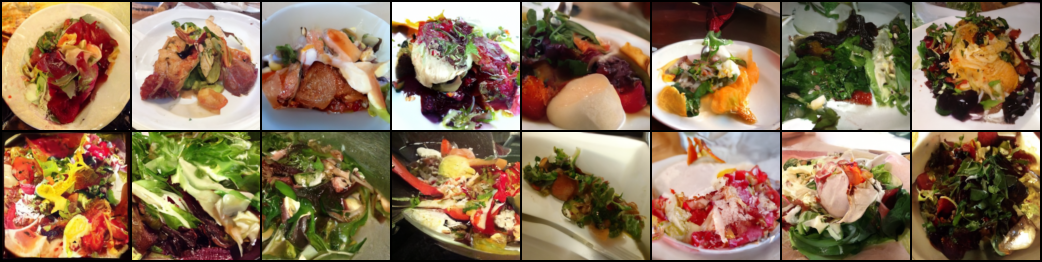

In [20]:
sampled_images = sample_images(
    model=T, 
    noise_scheduler=noise_scheduler, 
    device=config.device, 
    c=6,
)

show_images(sampled_images)

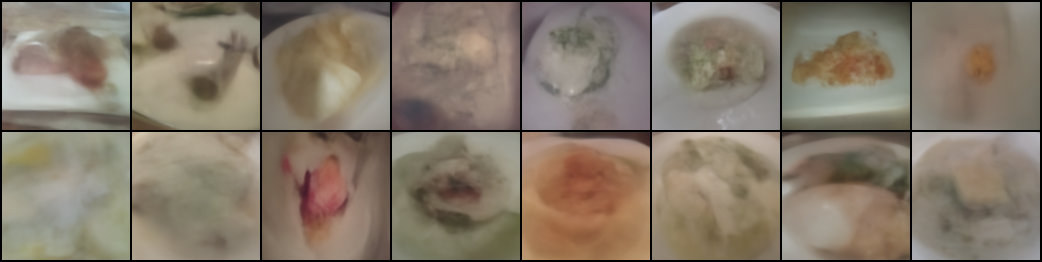

In [22]:
sampled_images = sample_images(
    model=S, 
    noise_scheduler=noise_scheduler, 
    device=config.device, 
    c=6,
    num_inference_steps=4,
)

show_images(sampled_images)

# Prepair or model for Accelerate trainig

In [10]:
from accelerate import Accelerator

accelerator = Accelerator(
    mixed_precision=config.mixed_precision,
    gradient_accumulation_steps=config.gradient_accumulation_steps, 
)

train_dataloader, S, T, D, S_optimizer, D_optimizer = accelerator.prepare(
    train_dataloader, S, T, D, S_optimizer, D_optimizer
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [11]:
for epoch in range(100):
    S_loss, D_loss = train_epoch(S, T, D, 
                S_optimizer, D_optimizer, 
                accelerator=accelerator, 
                adversarial_loss=nn.CrossEntropyLoss().to(config.device), 
                reconstruction_loss=nn.MSELoss().to(config.device), 
                lambd=1.0,
                dataloader=train_dataloader, 
                device=config.device
               )

    if (epoch + 1) % 5 == 0:
        generated_images = eval_epoch(S, S_noise_scheduler, config.device, num_inference_steps=4)
        print(generated_images)
        pil_images = show_images(generated_images)
        plt.imshow(pil_images)
        pil_images.save(f"{epoch}.jpg")

        torch.save(S, f"celeba_unconditional_add/S_{epoch}.pt")
        torch.save(D, f"celeba_unconditional_add/D_{epoch}.pt")

  0%|                                                                                        | 1/4735 [00:07<9:15:51,  7.05s/it]

tensor(0.7412, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7234, device='cuda:0', grad_fn=<DivBackward0>)


  0%|                                                                                       | 2/4735 [00:32<23:51:43, 18.15s/it]

tensor(0.7444, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6876, device='cuda:0', grad_fn=<DivBackward0>)


  0%|                                                                                       | 2/4735 [00:45<30:03:06, 22.86s/it]


KeyboardInterrupt: 